In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import NSMap as ns

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'numpy'

In [3]:
import os

platform.system()

NameError: name 'platform' is not defined

In [3]:
epsilon = 0.77
alpha = 0.28
s0 = 1370
sigma = 5.670374419 * (10 ** (-8))

In [4]:
(s0*(1-alpha)/sigma) ** (1/4)

363.1703058218866

In [24]:
((s0 * (1 - alpha))/(4 * sigma * (1 - epsilon / 2))) ** (1/4)

269.86208459150777

In [17]:
(s0 * (1 - alpha)) / (4 * (1 - epsilon / 2) * (288**4))

5.828381962044286e-08

In [15]:
sigma

5.670374419e-08

# Linear Different Nonstationarity Types
Test how NSMap does for simple linear systems.


In [3]:
# General function which runs the simulations for all model types
def runSimulation(f, filename, N_replicates = 100, E_max = 8):
    results = np.array([ns.get_delta_agg(f(), E_max, return_forecast_skill=True)
                        for i in range(int(N_replicates))])
    np.savetxt(f"../results/linear_results/{filename}.csv", results, fmt="%0.4f,%0.4f,%0.4f", header = "delta, theta, r squared")

In [42]:
length = 200
E_max = 8
N_replicates = 100

In [5]:
# Stationary
def generate_stationary():
    theta = lambda t: np.pi / 6
    x0 = rand.random(1)[0] * 2 * np.pi
    return np.sin(theta(0) * np.arange(length) + x0) * np.sqrt(2) + rand.normal(0,0.1,length)

In [8]:
runSimulation(generate_stationary, "linear_stationary")

KeyboardInterrupt: 

In [6]:
# Increasing Mean

def generate_mean_change():
    x0 = rand.random(1)[0] * 2 * np.pi
    theta = np.pi / 6
    return np.sqrt(2) * np.sin(theta * np.arange(length) + x0) + np.linspace(0,1,num=length) + rand.normal(0, 0.1, length)

In [ ]:
runSimulation(generate_mean_change, "linear_mean_change")

In [7]:
# Increasing Amplitude
def generate_variance_change():
    x0 = rand.random(1)[0] * 2 * np.pi
    theta = np.pi / 6 # (0.5+t)*np.pi/6
    # ts = np.linspace(0.1,1,num=length) * (np.sqrt(2) * np.sin(theta * np.arange(length)) + rand.normal(0, 0.1, length))
    # ts = np.array([rand.normal(0,v) for v in np.linspace(2,8,num=200)])
    ts = np.linspace(1,2,num=length) * np.sqrt(2) * np.sin(theta * np.arange(length) + x0) + rand.normal(0, 0.1, length)
    
    return ts

In [ ]:
runSimulation(generate_variance_change, "linear_variance_change")

In [8]:
# Increasing Oscillation Frequency
def generate_speed_change():
    x0 = rand.random(1)[0] * 2 * np.pi
    theta = lambda t: (0.5+t)*np.pi/6
    ts = np.sqrt(2) * np.sin(theta(np.linspace(0,1,num=length)) * np.arange(length) + x0) + rand.normal(0, 0.1, length)
    
    return ts

In [ ]:
runSimulation(generate_speed_change, "linear_speed_change")

In [193]:
def generate_ricker_series(k):
    
    x0 = k(0)
    mu = 0.1

    ts = np.zeros(length)
    ts[0] = x0
    ricker = lambda x, t: x * np.exp(1 - x / k(t)) + mu * rand.normal(0, 1)

    for i in range(1, len(ts)):
        ts[i] = ricker(ts[i-1], (i-1)/(length-1))

    return ns.standardize(ts)

# Linearly increasing mean with normal process noise
def generate_equilibrium_mean_change():
    k = lambda t: 1 + t
    return generate_ricker_series(k)

# Linearly increasing mean with normal process noise
def generate_equilibrium():
    k = lambda t: 1
    return generate_ricker_series(k)

In [185]:
runSimulation(generate_equilibrium_mean_change, "equilibrium_mean_change_process_noise")

In [ ]:
runSimulation(generate_equilibrium, "equilibrium_process_noise")

In [202]:
# Results

table = np.loadtxt("../results/linear_results/equilibrium_mean_change_process_noise.csv", delimiter=",")
print(f"Proportion of nonstationary equilibrium Ricker classified as nonstationary: {np.mean(table[:,0] > 0.1)}")

table = np.loadtxt("../results/linear_results/equilibrium_process_noise.csv", delimiter=",")
print(f"Proportion of stationary equilibrium Ricker classified as stationary: {np.mean(table[:,0] < 0.1)}")

Proportion of nonstationary equilibrium Ricker classified as nonstationary: 1.0
Proportion of stationary equilibrium Ricker classified as stationary: 0.71


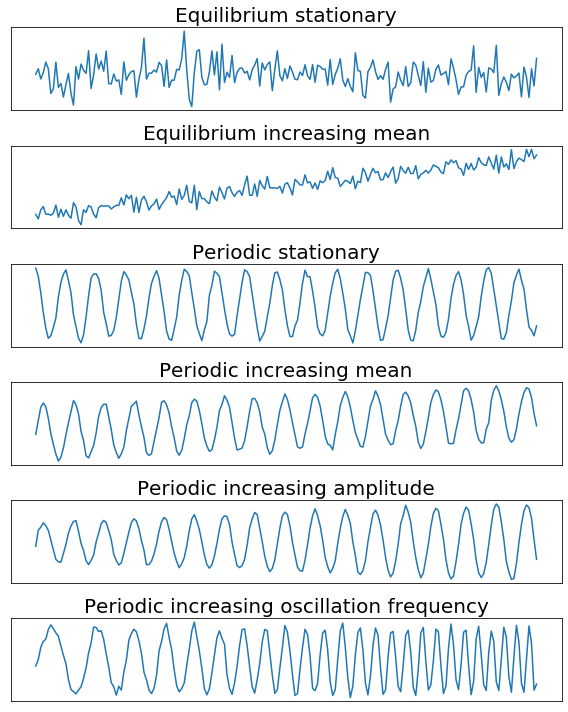

In [205]:
fig, ax = plt.subplots(6,figsize=(8,10))

ax[0].plot(generate_equilibrium())
ax[0].set_title("Equilibrium stationary", fontsize = 20)
ax[1].plot(generate_equilibrium_mean_change())
ax[1].set_title("Equilibrium increasing mean", fontsize = 20)
ax[2].plot(generate_stationary())
ax[2].set_title("Periodic stationary", fontsize = 20)
ax[3].plot(generate_mean_change())
ax[3].set_title("Periodic increasing mean", fontsize = 20)
ax[4].plot(generate_variance_change())
ax[4].set_title("Periodic increasing amplitude", fontsize = 20)
ax[5].plot(generate_speed_change())
ax[5].set_title("Periodic increasing oscillation frequency", fontsize = 20)

for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.savefig("../figures_eps/example_series/Figure_S1.eps", format="eps", bbox_inches="tight")